# Classification with `QNNClassifier`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevRx
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNClassifier, LogLoss
from squlearn.optimizers import SLSQP

In [2]:
executor = Executor()

## Classifier Setup
Let's start by defining a PQC

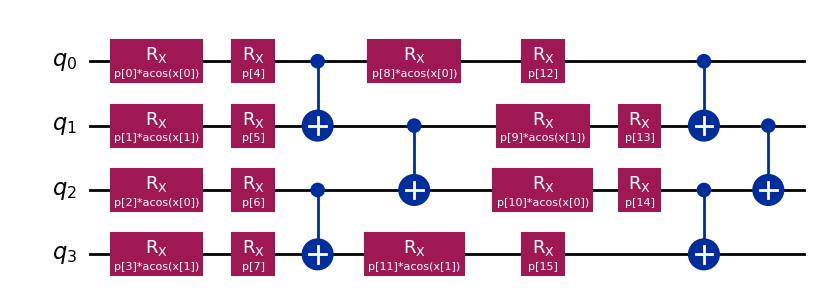

In [3]:
nqubits = 4

number_of_layers = 2
pqc = ChebyshevRx(nqubits, 2, num_layers=number_of_layers)
pqc.draw("mpl")

Next, we also need a Expectation Operator

In [4]:
cost_op = [SummedPaulis(nqubits), SummedPaulis(nqubits), SummedPaulis(nqubits)]
# cost_op = SummedPaulis(nqubits)
print(cost_op)

[SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])]), SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])]), SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])])]


Now we're ready to define the `QNNClassifier` with randomly initialized parameters for the PQC and the Operator

In [5]:
clf = QNNClassifier(pqc, cost_op, executor, LogLoss(eps=1e-9), SLSQP())

C:\Users\mow\Documents\AutoQML\squlearn\src\squlearn\qnn\lowlevel_qnn\lowlevel_qnn.py:43: UserWarning: Primitive argument is not supported for PennyLane. Ignoring...
  warn("Primitive argument is not supported for PennyLane. Ignoring...")


## Generate Dataset

We use the `make_blobs` dataset from scikit-learn with 60 data points in two classes. We continue to scale the data and split it into a set for training and one for testing.

In [6]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = make_blobs(60, centers=3, random_state=0)
y = np.stack([y == 0, y == 1, y == 2], axis=1, dtype=int)
X = MinMaxScaler((-0.9, 0.9)).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Optimization

Now we're ready to fit the `QNNClassifier`.

In [7]:
clf.fit(X_train, y_train)

fit: 100%|██████████| 100/100 [03:13<00:00,  1.94s/it]


## Evaluation
Let's check the trained parameters.

In [8]:
print("Result Param:", clf._param)
print("Result ParamOp:", clf._param_op)

Result Param: [  1.23958601   4.98442677   5.44852723   3.61726061  -0.71950182
  -0.45293036 -10.40781322   2.60750302  -0.21659846   3.04507631
  -0.85382491   3.61726061   0.68732202   3.52726238  -3.03762659
  -2.44822246]
Result ParamOp: [  19.22061674   62.80708476 -150.94992317 -116.24301538  208.38069066
  -39.63311389   62.2006118    76.35696686 -112.51886877 -399.47432136
   23.41249715 -122.00769656   77.59295631  231.76188415  194.09363071]


Also, let's check the performance of the classifier on the test set using the mean accuracy.

In [9]:
clf.score(X_test, y_test)

0.8333333333333334

Finally, let's visualize the classifiers performance. We plot the training and test set as well as the decision boundary of the `QNNClassifier`.

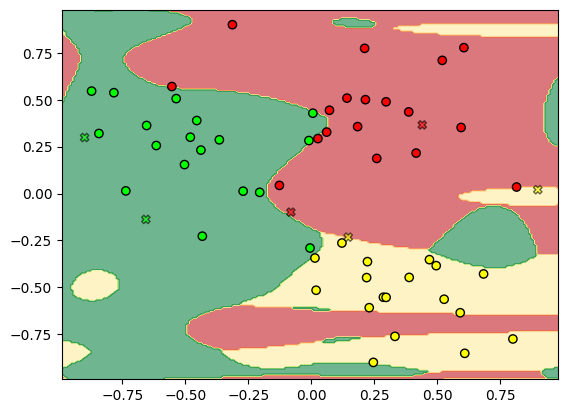

In [10]:
from matplotlib.colors import ListedColormap

xx, yy = np.meshgrid(np.arange(-0.99, 0.99, 0.01), np.arange(-0.99, 0.99, 0.01))

cm = plt.cm.RdYlGn
cm_bright = ListedColormap(["#FF0000", "#FFFF00", "#00FF00"])

Z = np.argmax(clf.predict_proba(np.column_stack([xx.ravel(), yy.ravel()])), axis=1)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=0.6)

plt.scatter(
    X_train[:, 0], X_train[:, 1], c=np.dot(y_train, [0, 1, 2]), cmap=cm_bright, edgecolors="k"
)
# and testing points
plt.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=np.dot(y_test, [0, 1, 2]),
    cmap=cm_bright,
    alpha=0.6,
    marker="X",
    edgecolors="k",
)